In [1]:
# import library
import numpy as np 
import pandas as pd
import re
import os
import pickle

import matplotlib.pyplot as plt
%matplotlib inline


import keras
import keras.utils
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten

from functools import partial
from keras import metrics

In [2]:
MAX_SEQUENCES_LENGTH = 50 # Maximum kata pada kalimat
MAX_NB_WORDS = 6000 # Vocabulary size
EMBEDDING_DIM = 50 # Dimensions of Glove word vector kadang bisa juga 100

In [3]:
# membuka dataset yg telah di split
with open('split_dataset/train70_test30.pickle', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

# membuka word_index
with open('split_dataset/word_index.pickle', 'rb') as f:
    word_index = pickle.load(f)

In [4]:
classes = ['0', '1', '2']

In [5]:
# open Glove
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join('dataset/glove/vectors.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 331286 word vectors.


In [6]:
# Use GloVe as Word Embedding
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
       

In [7]:
# Embedding layer with glove
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCES_LENGTH, weights=[embedding_matrix], trainable=True)

In [8]:
# Create Model CNN
def create_model():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.3))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [9]:
# Train Model
cnn_model = create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            130450    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 128)           19328     
_________________________________________________________________
dropout (Dropout)            (None, 50, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 64)            24640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 64)            0

In [10]:
# Test epoch 10, 20, dan 50
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
31/31 [==============================] - 16s 43ms/step - loss: 1.3889 - accuracy: 0.4154 - val_loss: 1.0496 - val_accuracy: 0.4893
Epoch 2/10
31/31 [==============================] - 0s 9ms/step - loss: 1.0579 - accuracy: 0.4740 - val_loss: 1.0443 - val_accuracy: 0.4893
Epoch 3/10
31/31 [==============================] - 0s 7ms/step - loss: 1.0303 - accuracy: 0.4845 - val_loss: 1.0391 - val_accuracy: 0.4941
Epoch 4/10
31/31 [==============================] - 0s 8ms/step - loss: 1.0214 - accuracy: 0.5023 - val_loss: 1.0304 - val_accuracy: 0.4964
Epoch 5/10
31/31 [==============================] - 0s 7ms/step - loss: 1.0252 - accuracy: 0.4858 - val_loss: 1.0147 - val_accuracy: 0.5036
Epoch 6/10
31/31 [==============================] - 0s 7ms/step - loss: 1.0167 - accuracy: 0.5094 - val_loss: 0.9994 - val_accuracy: 0.5416
Epoch 7/10
31/31 [==============================] - 0s 7ms/step - loss: 0.9632 - accuracy: 0.5374 - val_loss: 0.9781 - val_accuracy: 0.5772
Epoch 8/10
31/31 [

CNN Accuracy: 0.5938242280285035


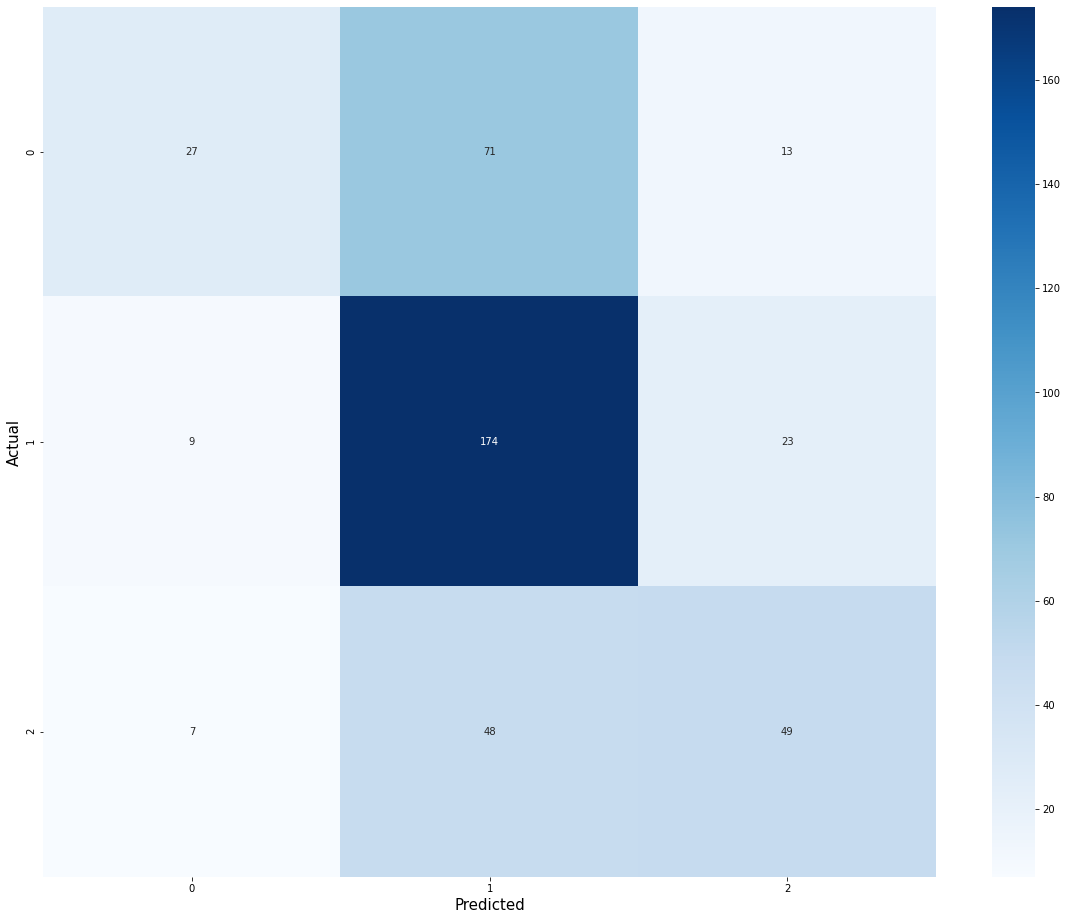

In [13]:
# confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
ypred = cnn_model.predict(X_test)
cnn_accuracy = accuracy_score(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
print("CNN Accuracy:",cnn_accuracy)
cnn_cn = confusion_matrix(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
plt.subplots(figsize=(20,16))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cmap="Blues",cbar=True,xticklabels=classes,yticklabels=classes)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
# klu mau save gambar
plt.savefig('model70_e10.png')
plt.show()

In [14]:
# save model
cnn_model.save('model70_e10.h5')

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=-1), ypred.argmax(axis=-1),target_names= classes))

              precision    recall  f1-score   support

           0       0.63      0.24      0.35       111
           1       0.59      0.84      0.70       206
           2       0.58      0.47      0.52       104

    accuracy                           0.59       421
   macro avg       0.60      0.52      0.52       421
weighted avg       0.60      0.59      0.56       421



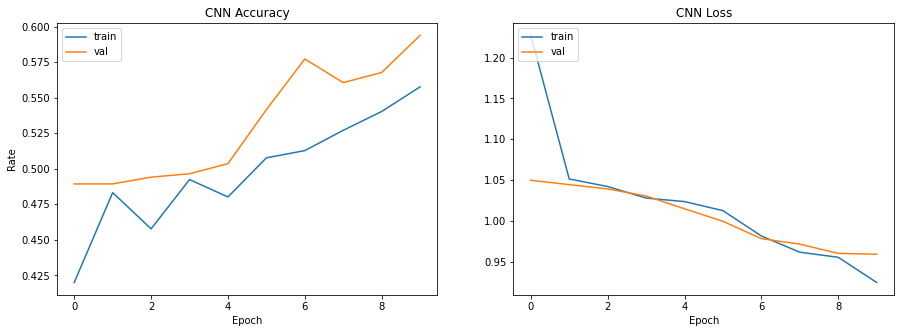

In [15]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(cnn_history.history["accuracy"],label="accuracy")
axe1[0].plot(cnn_history.history["val_accuracy"],label="accuracy")
axe1[0].legend(['train', 'val'], loc='upper left')
axe1[1].plot(cnn_history.history["loss"],label="loss")
axe1[1].plot(cnn_history.history["val_loss"],label="loss")
axe1[1].legend(['train', 'val'], loc='upper left')
axe1[0].title.set_text("CNN Accuracy")
axe1[1].title.set_text("CNN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()

In [ ]:
# load model (klu mau mencoba lagi model yg habis di test)
# from keras.models import load_model
# cnn_test = load_model('model90_e10.h5')